**LR**
http://www.jiehuozhe.com/article/3

LR建模时，要求特征具有线性关系，而实际应用中很少有满足这个假设关系的，因此LR模型效果很难达到应用要求。如果对特征离散化，每个离散化的特征取值都有一个权重系数表示特征重要性，这样就能够更准确的建模，也就能够获得更精准的模型。

**虚拟陷阱（dummy variable trap）：**

引入正则项。既然有很多等价的参数，那我们可以考虑从这些等价的参数中选择我们最想要的，常用的做法就是使用正则项，控制参数的取值范围。

使用哑变量替代One-Hot编码。此时上面公式中x3=0，模型只有唯一解

**CookBook**  https://github.com/nfmcclure/tensorflow_cookbook/tree/master/03_Linear_Regression/08_Implementing_Logistic_Regression

https://www.zybuluo.com/rianusr/note/1159468

# Logistic Regression

逻辑回归是一种广义的线性回归模型，P的logit变换.
This function shows how to use TensorFlow to solve logistic regression. $ \textbf{y} = sigmoid(\textbf{A}\times \textbf{x} + \textbf{b})$

![Image of Yaktocat](http://static.zybuluo.com/rianusr/xci4rboqftu1gw4t4bx8o0yr/image_1ce8o2idm2mh1r331rfgp4mvfa26.png)

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops
import os.path
import csv
import pandas as pd

In [163]:
ops.reset_default_graph()

# Create graph
sess = tf.Session()

### Obtain and prepare data for modeling

In [164]:
# index_col=None is for index, index_col=0 is for unnamed
data = pd.read_csv('processed_data.csv', index_col=0)
data.head()

,International plan,Voice mail plan,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,...,Total intl calls,Customer service calls,average day charge,average eve charge,average night charge,average intl charge,Area_code_408,Area_code_415,Area_code_510,Churn
0,0,1,0,0,0,0,0,0,0,0,...,-0.597527,-0.429172,-0.276822,0.014900,0.402666,-0.070614,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,-0.597527,-0.429172,0.532952,0.005521,-0.452165,-0.076752,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.216894,-1.191955,-0.170897,0.041106,-1.098729,-0.043000,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1.031314,0.333610,-0.118374,0.050503,0.183244,-0.045094,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,-0.597527,1.096392,-0.095093,-0.015797,0.191546,-0.095573,0,1,0,0


In [165]:
# set for reproducible results
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

In [166]:
# Pull out target variable
y_vals = data['Churn']
y_vals = y_vals.to_frame()
# Pull out predictor variables
x_vals = data.drop(y_vals,axis=1)
x_vals.head()

,International plan,Voice mail plan,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,...,Total night calls,Total intl calls,Customer service calls,average day charge,average eve charge,average night charge,average intl charge,Area_code_408,Area_code_415,Area_code_510
0,0,1,0,0,0,0,0,0,0,0,...,-0.469031,-0.597527,-0.429172,-0.276822,0.014900,0.402666,-0.070614,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0.149054,-0.597527,-0.429172,0.532952,0.005521,-0.452165,-0.076752,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0.200561,0.216894,-1.191955,-0.170897,0.041106,-1.098729,-0.043000,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,-0.572045,1.031314,0.333610,-0.118374,0.050503,0.183244,-0.045094,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1.076181,-0.597527,1.096392,-0.095093,-0.015797,0.191546,-0.095573,0,1,0


In [167]:
# Split data into train/test = 80%/20%
train_indices = round(len(x_vals)*0.8)
test_indices = len(x_vals) - train_indices
print (train_indices,test_indices)

2133 533


In [168]:
x_vals_train = x_vals[:train_indices]
x_vals_test = x_vals[train_indices:]
y_vals_train = y_vals[:train_indices]
y_vals_test = y_vals[train_indices:]

In [169]:
x_vals_train.shape

(2133, 67)

### Define Tensorflow computational graph

In [170]:
# Initialize placeholders
x_data = tf.placeholder(shape=[None, 67], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 参数初始化
# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[67,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

\begin{eqnarray} 
  C = -\frac{1}{n} \sum_x \left[y \ln a + (1-y ) \ln (1-a) \right],
\end{eqnarray}

a = predicted

Cross-entropy could address the learning **slowdown**. where n is the total number of items of training data, the sum is over all training inputs, x, and y is the corresponding desired output.
http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function

In [171]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

## Train model

In [172]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
# calculate coorect percentage, then casts a tensor to a new type.
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
# Reduces input_tensor along the dimensions
accuracy = tf.reduce_mean(predictions_correct)

In [173]:
print (accuracy)

Tensor("Mean_1:0", shape=(), dtype=float32)


In [177]:
y_vals_train.head()

,Churn
0,0
1,0
2,0
3,0
4,0


In [178]:
print ("y_vals_train_shape:",y_vals_train.shape)

y_vals_train_shape: (2133, 1)


In [179]:
print ("x_vals_train_shape:",x_vals_train.shape)

x_vals_train_shape: (2133, 67)


### Display model performance¶

In [182]:
# Declare batch size
batch_size = 25

# Training loop
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    # Generates a random sample from a given 1-D array
    # size: Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. Default is None, in which case a single value is returned.
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    print (rand_index.shape)  # 25
    print (rand_index.dtype)  #int64
    
    print ("x_vals_train.shape:",x_vals_train.shape)
    print ("y_vals_train.shape:",y_vals_train.shape)
    
    # Bug
    rand_x = x_vals_train[rand_index]
    # Transpose ?
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    print (rand_x.shape)
    print (rand_x.dtype)
    # Transpose
    rand_y = np.transpose([y_vals_train[rand_index]])
    print (rand_y.shape)
    print (rand_y.dtype)
    
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if (i+1)%300==0:
        print('Loss = ' + str(temp_loss_train))

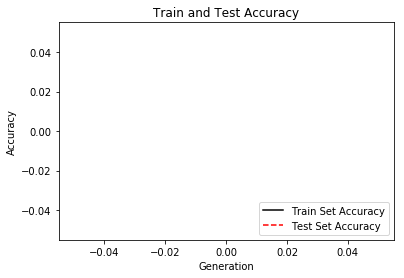

In [161]:
%matplotlib inline

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()